# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf

2024-11-08 11:56:59.681661: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 11:56:59.741900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 11:57:00.010824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 11:57:00.340950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 11:57:00.440914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 11:57:00.843125: I tensorflow/core/platform/cpu_feature_gu

In [2]:
df=pd.read_parquet("data/fhvhv_tripdata_2023-01.parquet")

In [3]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-01-01 00:18:06,2023-01-01 00:19:24,2023-01-01 00:19:38,2023-01-01 00:48:07,48,68,0.94,...,2.30,2.75,0.0,5.22,27.83,N,N,,N,N
1,HV0003,B03404,B03404,2023-01-01 00:48:42,2023-01-01 00:56:20,2023-01-01 00:58:39,2023-01-01 01:33:08,246,163,2.78,...,5.34,2.75,0.0,0.00,50.15,N,N,,N,N
2,HV0003,B03404,B03404,2023-01-01 00:15:35,2023-01-01 00:20:14,2023-01-01 00:20:27,2023-01-01 00:37:54,9,129,8.81,...,2.16,0.00,0.0,0.00,20.22,N,N,,N,N
3,HV0003,B03404,B03404,2023-01-01 00:35:24,2023-01-01 00:39:30,2023-01-01 00:41:05,2023-01-01 00:48:16,129,129,0.67,...,1.22,0.00,0.0,0.00,7.90,N,N,,N,N
4,HV0003,B03404,B03404,2023-01-01 00:43:15,2023-01-01 00:51:10,2023-01-01 00:52:47,2023-01-01 01:04:51,129,92,4.38,...,1.82,0.00,0.0,0.00,16.48,N,N,,N,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18479031 entries, 0 to 18479030
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

# Data Cleanup / Preprocessing

In [5]:
# Remove Null Values
df.dropna(inplace=True)

In [6]:
# Drop unused columns
df.drop(['dispatching_base_num','originating_base_num','base_passenger_fare','tolls','bcf','sales_tax','congestion_surcharge','airport_fee','tips','driver_pay','access_a_ride_flag','wav_match_flag','wav_request_flag'],axis=1, inplace=True)

In [7]:
# Extracting only uber rides
df = df[df['hvfhs_license_num'] == 'HV0003']
df.drop(['hvfhs_license_num'],axis=1, inplace=True)

In [8]:
# Calculate the 99th percentile value for trip_miles
trip_miles_99th_percentile = df['trip_miles'].quantile(0.99)
df = df[df['trip_miles'] < trip_miles_99th_percentile]

# Calculate the 99th percentile value for trip_time
trip_time_99th_percentile = df['trip_time'].quantile(0.99)
df = df[df['trip_time'] < trip_time_99th_percentile]

In [9]:
# Create cyclic features for time of the day and day of the week
df['hour'] = df['request_datetime'].dt.hour
df['weekday'] = df['request_datetime'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

In [10]:
# Aggregate the data to get the demand for each PULocationID
demand = df.groupby(['PULocationID', 'DOLocationID', 'hour', 'weekday']).size().reset_index(name='demand')

In [11]:
# Merge the cyclic features back to the demand dataframe
demand = demand.merge(df[['PULocationID', 'DOLocationID', 'hour', 'weekday', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']].drop_duplicates(), on=['PULocationID', 'DOLocationID', 'hour', 'weekday'])

In [12]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2521697 entries, 0 to 2521696
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   PULocationID  int64  
 1   DOLocationID  int64  
 2   hour          int32  
 3   weekday       int32  
 4   demand        int64  
 5   hour_sin      float64
 6   hour_cos      float64
 7   weekday_sin   float64
 8   weekday_cos   float64
dtypes: float64(4), int32(2), int64(3)
memory usage: 153.9 MB


In [13]:
demand.head()

,PULocationID,DOLocationID,hour,weekday,demand,hour_sin,hour_cos,weekday_sin,weekday_cos
0,1,1,6,0,1,1.000000,6.123234e-17,0.000000,1.000000
1,1,1,6,1,1,1.000000,6.123234e-17,0.781831,0.623490
2,1,1,15,1,1,-0.707107,-7.071068e-01,0.781831,0.623490
3,1,1,15,3,1,-0.707107,-7.071068e-01,0.433884,-0.900969
4,2,76,13,4,1,-0.258819,-9.659258e-01,-0.433884,-0.900969


In [14]:
# Calculate the 1st percentile value for demand
demand_1st_percentile = demand['demand'].quantile(0.005)
demand = demand[demand['demand'] > demand_1st_percentile]

In [15]:
# Define the bins and labels
bins = [0, 1, 2, 3, 4, 5, float('inf')]
labels = [-1 ,0, 1, 2, 3, 4]

# Create a new column 'demand_category' with the binned values
demand['demand_category'] = pd.cut(demand['demand'], bins=bins, labels=labels)

In [16]:
# Convert the 'demand_category' column to integer type
demand['demand_category'] = demand['demand_category'].astype(int)

In [18]:
demand['demand_category'].replace({2: 1, 3: 1, 4: 2}, inplace=True)

/tmp/ipykernel_90563/2874403829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demand['demand_category'].replace({2: 1, 3: 1, 4: 2}, inplace=True)


In [19]:
demand.to_csv('data/demand.csv', index=False)

# Visualization

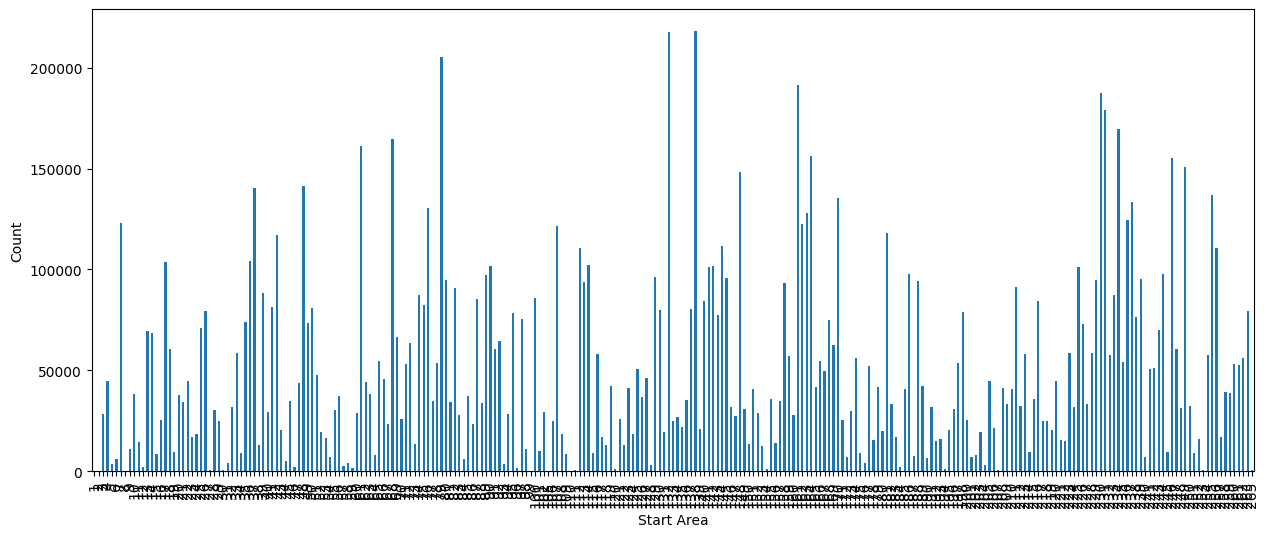

In [20]:
plt.figure(figsize=(15,6))
df['PULocationID'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Start Area")
plt.ylabel("Count")
plt.show()

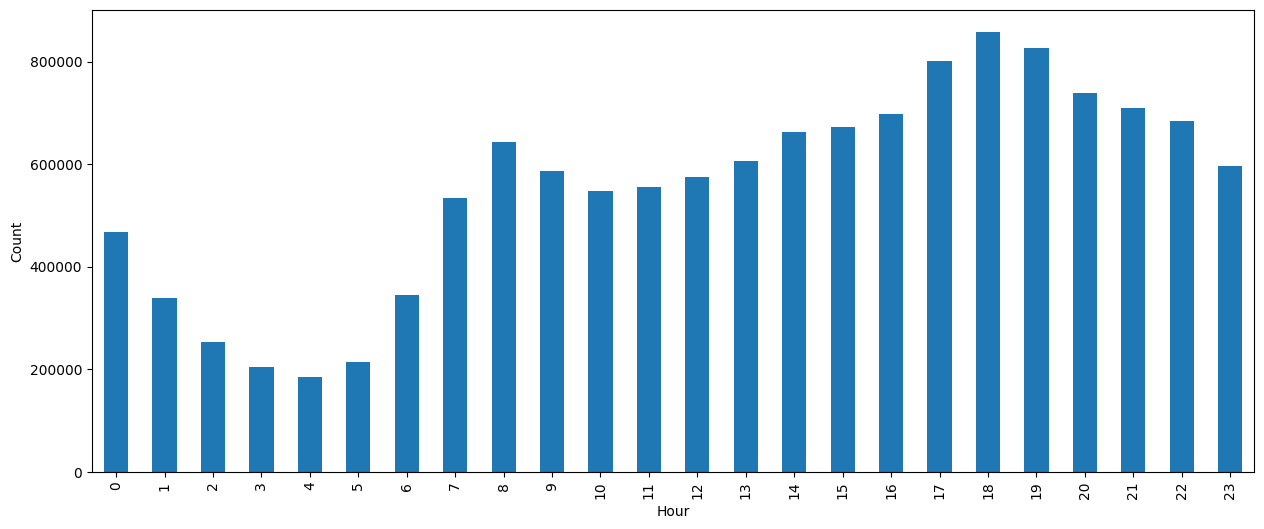

In [21]:
plt.figure(figsize=(15,6))
df['request_datetime'].dt.hour.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

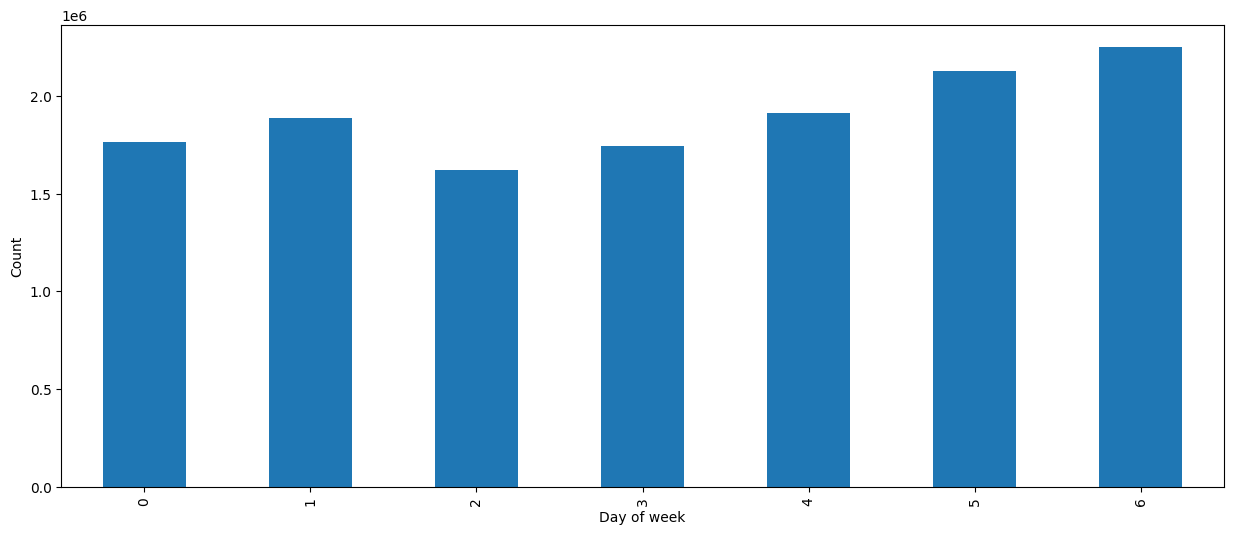

In [22]:
plt.figure(figsize=(15,6))
df['request_datetime'].dt.dayofweek.value_counts(sort=False).sort_index().plot(kind='bar')
#df['request_datetime'].dt.day_name().value_counts(sort=False).plot(kind='bar')
plt.xlabel("Day of week")
plt.ylabel("Count")
plt.show()

# Predicting Demand

In [23]:
X = demand[['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'PULocationID']]
y = demand['demand_category']

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Unloading the dataframe to save memory
df = []
demand = []

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [28]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/lenovo/Documents/Major Project/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,739 (18.51 KB)

 Trainable params: 4,739 (18.51 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

model.save('model.keras')

Epoch 1/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 255s 7ms/step - accuracy: 0.3808 - loss: 1.1475 - val_accuracy: 0.4103 - val_loss: 1.0798
Epoch 2/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 255s 7ms/step - accuracy: 0.4099 - loss: 1.0797 - val_accuracy: 0.4130 - val_loss: 1.0781
Epoch 3/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - accuracy: 0.4120 - loss: 1.0788 - val_accuracy: 0.4117 - val_loss: 1.0780
Epoch 4/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - accuracy: 0.4125 - loss: 1.0789 - val_accuracy: 0.4125 - val_loss: 1.0787
Epoch 5/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.4131 - loss: 1.0783 - val_accuracy: 0.4133 - val_loss: 1.0781
Epoch 6/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.4128 - loss: 1.0784 - val_accuracy: 0.4123 - val_loss: 1.0781
Epoch 7/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - accuracy: 0.4135 - loss: 1.0782 - val_accuracy: 0.4129 - val_loss: 1.0778
Epoch 8/10
37197/37197 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - ac

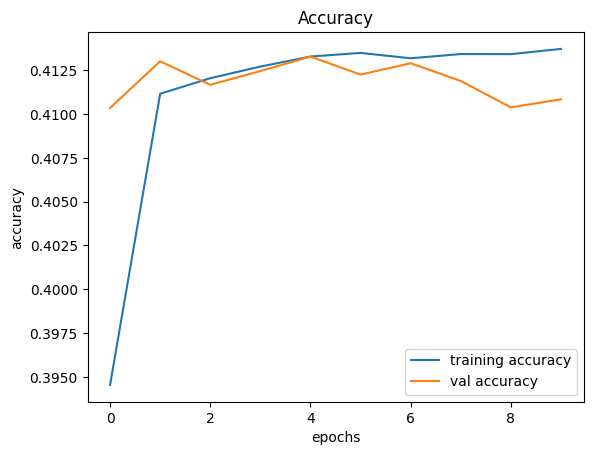

In [30]:
#plotting graphs for accuracy 
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Evaluation

In [31]:
# Score
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 1.0788711309432983
Test accuracy 0.4108462929725647


In [32]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

9300/9300 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.42      0.05      0.09     81510
           1       0.38      0.12      0.18     99122
           2       0.42      0.91      0.57    116944

    accuracy                           0.41    297576
   macro avg       0.40      0.36      0.28    297576
weighted avg       0.40      0.41      0.31    297576

[[  4117  11150  66243]
 [  3916  12134  83072]
 [  1874   9063 106007]]


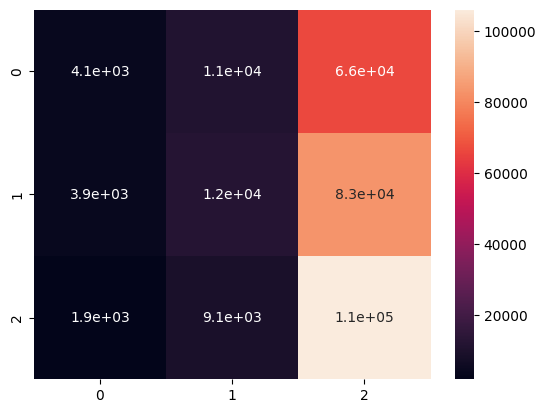

In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cm,annot=True)
plt.savefig('h1.png')

In [36]:
import datetime

def predict_high_demand_areas(date_time):
    # Extract features from the date_time
    hour = date_time.hour
    weekday = date_time.weekday()
    
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    weekday_sin = np.sin(2 * np.pi * weekday / 7)
    weekday_cos = np.cos(2 * np.pi * weekday / 7)
    
    # Create a dataframe with all possible PULocationID values
    PULocationIDs = X['PULocationID'].unique()
    data = pd.DataFrame({
        'hour_sin': [hour_sin] * len(PULocationIDs),
        'hour_cos': [hour_cos] * len(PULocationIDs),
        'weekday_sin': [weekday_sin] * len(PULocationIDs),
        'weekday_cos': [weekday_cos] * len(PULocationIDs),
        'PULocationID': PULocationIDs
    })
    
    # Make predictions
    predictions = model.predict(data)
    predicted_categories = np.argmax(predictions, axis=1)
    
    # Filter for high demand areas (level 4)
    high_demand_areas = data[predicted_categories == 2]
    
    return high_demand_areas['PULocationID'].values

# Example usage
date_time = datetime.datetime(2023, 1, 1, 8, 0)
high_demand_areas = predict_high_demand_areas(date_time)
print(high_demand_areas)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 265]
